# Plan C: 混合方案优化 (电梯 + 火箭) - 标准差版本

## MCM/ICM 2025 - Question 2: 非完美条件下的优化

**与CV版本的区别**:
1. 稳定性指标使用 **标准差 σ** 而非变异系数 CV
2. 时间计算完全基于 **期望值** (考虑故障概率)

**决策变量**: α ∈ [0, 1]
- α = 0: 纯火箭 (Plan B)
- α = 1: 纯电梯 (Plan A)
- 0 < α < 1: 混合方案 (Plan C)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

print("Libraries imported successfully!")

Libraries imported successfully!


In [14]:
# ==================== 基础参数 (基于研究数据校正 - 2025.01) ====================
M = 10**8                 # 总运输量 (吨)

# ==================== 电梯参数 ====================
# 数据来源: Wikipedia - Space Elevator Economics (Edwards估计)
# - 边际成本: ~$220/kg ($100/lb) to GEO = $2.2×10^5/ton
# - 首台建造: ~$40B, 后续 ~$14.3B
# - 运营成本: $1.56B for first 10 years

E_E_base = 179000 * 3     # 电梯基础年运输能力 (吨/年)
C_E = 2.2 * 10**5         # 电梯边际成本 (USD/吨) - Edwards estimate ~$220/kg
F_E = 1.2 * 10**8         # 电梯固定成本 (USD/年) - $1.56B/10yrs average
p_E = 0.003               # 电梯年故障概率
sigma_swing = 1.5         # 缆绳摆动参数 (度) - 考虑Coriolis力、太阳风、引力扰动
theta_limit = 4.0         # 摆动角度限制 (度) - 工程设计容差
val_rep_E = 5 * 10**8     # 电梯维修费用 (USD)

# ==================== 火箭参数 ====================
# 数据来源: Wikipedia - Falcon Heavy, SpaceX官网
# - 可回收发射: $97M; 全抛弃: $150M
# - LEO成本: $2,350/kg; GTO成本: $5,620/kg
# - 2050技术进步因子: 0.5 (基于SpaceX Starship愿景$10/kg趋势)

P_avg = 125               # 火箭平均载荷 (吨/次)
f_avg = 1472              # 年发射频率 (次/年)
E_R = f_avg * P_avg       # 火箭年运输能力 (吨/年)
C_R = 1 * 10**5           # 火箭边际成本 (USD/吨) - $2,350/kg × 0.5 (2050 projected)
F_R = 5 * 10**7           # 火箭固定成本 (USD/年) - 发射场年度维护
q_R = 0.95                # 火箭发射成功概率
val_R = 7.5 * 10**6       # 单次发射成本 (USD)

# 电梯有效运输能力 (考虑摆动)
ff = 1 - exp(-theta_limit**2 / (2 * sigma_swing**2))
E_E = E_E_base * ff

N = f_avg  # 火箭年发射次数

print("=" * 60)
print("参数校正说明 (基于研究数据)")
print("=" * 60)
print(f"电梯边际成本 C_E: ${C_E:,.0f}/ton (~$220/kg, Edwards estimate)")
print(f"火箭边际成本 C_R: ${C_R:,.0f}/ton (~$1,175/kg, 2050 projected)")
print(f"电梯固定成本 F_E: ${F_E/10**8:.2f}亿USD/年")
print(f"火箭固定成本 F_R: ${F_R/10**7:.1f}千万USD/年")
print("-" * 60)
print(f"电梯有效年运输能力: {E_E:,.0f} 吨/年")
print(f"火箭有效年运输能力: {E_R:,.0f} 吨/年")
print(f"总运输量: {M:,.0f} 吨")

参数校正说明 (基于研究数据)
电梯边际成本 C_E: $220,000/ton (~$220/kg, Edwards estimate)
火箭边际成本 C_R: $100,000/ton (~$1,175/kg, 2050 projected)
电梯固定成本 F_E: $1.20亿USD/年
火箭固定成本 F_R: $5.0千万USD/年
------------------------------------------------------------
电梯有效年运输能力: 521,660 吨/年
火箭有效年运输能力: 184,000 吨/年
总运输量: 100,000,000 吨


In [15]:
# ==================== Plan A: 纯电梯 (考虑故障的期望) ====================
def plan_A_stats():
    """计算纯电梯方案的期望和方差 (考虑故障)"""
    # 时间期望 (考虑故障导致的延迟)
    E_T_A = M / (E_E * (1 - p_E))
    Var_T_A = M * p_E / (E_E * (1 - p_E)**2)
    Std_T_A = sqrt(Var_T_A)
    
    # 成本期望 (考虑维修费用)
    E_C_A = (M * C_E + M * F_E / E_E + M * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
    Var_C_A = M * p_E * val_rep_E**2 / (E_E * (1 - p_E)**2) / 10**16
    Std_C_A = sqrt(Var_C_A)
    
    return E_T_A, Var_T_A, Std_T_A, E_C_A, Var_C_A, Std_C_A

E_T_A, Var_T_A, Std_T_A, E_C_A, Var_C_A, Std_C_A = plan_A_stats()
print("=" * 55)
print("Plan A (纯电梯) - 考虑故障概率 p_E =", p_E)
print("=" * 55)
print(f"时间期望 E[T]: {E_T_A:.2f} 年")
print(f"时间标准差 σ_T: {Std_T_A:.4f} 年")
print(f"时间变异系数 CV_T: {Std_T_A/E_T_A:.4f}")
print("-" * 55)
print(f"成本期望 E[C]: {E_C_A:.2f} 亿USD")
print(f"成本标准差 σ_C: {Std_C_A:.4f} 亿USD")
print(f"成本变异系数 CV_C: {Std_C_A/E_C_A:.4f}")

Plan A (纯电梯) - 考虑故障概率 p_E = 0.003
时间期望 E[T]: 192.27 年
时间标准差 σ_T: 0.7606 年
时间变异系数 CV_T: 0.0040
-------------------------------------------------------
成本期望 E[C]: 220232.92 亿USD
成本标准差 σ_C: 3.8031 亿USD
成本变异系数 CV_C: 0.0000


In [16]:
# ==================== Plan B: 纯火箭 (考虑故障的期望) ====================
def plan_B_stats():
    """计算纯火箭方案的期望和方差 (考虑发射失败)"""
    # 时间期望 (考虑失败重发)
    E_T_B = M / P_avg / (N * q_R)
    Var_T_B = (1 - q_R) * M**2 / (N**3 * q_R**3 * P_avg**2)
    Std_T_B = sqrt(Var_T_B)
    
    # 成本期望 (考虑失败损失)
    E_C_B = (M * C_R / q_R + val_R * M * (1 - q_R) / (P_avg * q_R) + 
             M / (N * q_R * P_avg)) / 10**8
    Var_C_B = (C_R**2 * P_avg * M * (1 - q_R) / q_R**2 + 
               val_R**2 * M * (1 - q_R) / (P_avg * q_R**2) + 
               (1 - q_R) * M**2 / (N**3 * q_R**3 * P_avg**2)) / 10**16
    Std_C_B = sqrt(Var_C_B)
    
    return E_T_B, Var_T_B, Std_T_B, E_C_B, Var_C_B, Std_C_B

E_T_B, Var_T_B, Std_T_B, E_C_B, Var_C_B, Std_C_B = plan_B_stats()
print("=" * 55)
print("Plan B (纯火箭) - 考虑失败概率 1-q =", 1-q_R)
print("=" * 55)
print(f"时间期望 E[T]: {E_T_B:.2f} 年")
print(f"时间标准差 σ_T: {Std_T_B:.4f} 年")
print(f"时间变异系数 CV_T: {Std_T_B/E_T_B:.4f}")
print("-" * 55)
print(f"成本期望 E[C]: {E_C_B:.2f} 亿USD")
print(f"成本标准差 σ_C: {Std_C_B:.4f} 亿USD")
print(f"成本变异系数 CV_C: {Std_C_B/E_C_B:.4f}")

Plan B (纯火箭) - 考虑失败概率 1-q = 0.050000000000000044
时间期望 E[T]: 572.08 年
时间标准差 σ_T: 3.4208 年
时间变异系数 CV_T: 0.0060
-------------------------------------------------------
成本期望 E[C]: 108421.05 亿USD
成本标准差 σ_C: 30.6892 亿USD
成本变异系数 CV_C: 0.0003


In [17]:
# ==================== Plan C: 混合方案 (基于期望计算) ====================
def plan_C_stats(alpha):
    """
    计算混合方案的期望和标准差
    alpha: 电梯运输比例 (0~1)
    
    关键公式 (完全基于期望):
    1. 时间: 并行运输，取两个期望的最大值
       E[T_C] = max(E[T_E], E[T_R])
    2. 成本: 独立系统，期望线性叠加，方差按比例平方叠加
       E[C_C] = α·E[C_E] + (1-α)·E[C_R]
       Var[C_C] = α²·Var[C_E] + (1-α)²·Var[C_R]
    """
    # === 电梯部分时间期望 (考虑故障) ===
    if alpha > 0:
        # E[T_E] = αM / (E_E × (1-p_E))
        E_T_E = alpha * M / (E_E * (1 - p_E))
        Var_T_E = alpha * M * p_E / (E_E * (1 - p_E)**2)
    else:
        E_T_E = 0
        Var_T_E = 0
    
    # === 火箭部分时间期望 (考虑失败) ===
    if alpha < 1:
        # E[T_R] = (1-α)M / (N × q × P_avg)
        E_T_R = (1 - alpha) * M / P_avg / (N * q_R)
        Var_T_R = (1 - q_R) * ((1 - alpha) * M)**2 / (N**3 * q_R**3 * P_avg**2)
    else:
        E_T_R = 0
        Var_T_R = 0
    
    # === 总时间 = max(E[T_E], E[T_R]) (并行运输) ===
    E_T_C = max(E_T_E, E_T_R)
    # 方差取主导方 (时间更长的那个系统)
    if E_T_E >= E_T_R:
        Var_T_C = Var_T_E
    else:
        Var_T_C = Var_T_R
    Std_T_C = sqrt(Var_T_C) if Var_T_C > 0 else 0
    
    # === 电梯部分成本期望 ===
    if alpha > 0:
        E_C_E = (alpha * M * C_E + 
                 alpha * M * F_E / E_E + 
                 alpha * M * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
        Var_C_E = (alpha**2 * M * p_E * val_rep_E**2 / (E_E * (1 - p_E)**2)) / 10**16
    else:
        E_C_E = 0
        Var_C_E = 0
    
    # === 火箭部分成本期望 ===
    if alpha < 1:
        M_R = (1 - alpha) * M
        E_C_R = (M_R * C_R / q_R + 
                 val_R * M_R * (1 - q_R) / (P_avg * q_R) + 
                 M_R / (N * q_R * P_avg)) / 10**8
        # 方差按(1-α)²比例
        Var_C_R = ((1 - alpha)**2 * 
                   (C_R**2 * P_avg * M * (1 - q_R) / q_R**2 + 
                    val_R**2 * M * (1 - q_R) / (P_avg * q_R**2) + 
                    (1 - q_R) * M**2 / (N**3 * q_R**3 * P_avg**2))) / 10**16
    else:
        E_C_R = 0
        Var_C_R = 0
    
    # === 总成本 (独立事件，期望相加，方差相加) ===
    E_C_C = E_C_E + E_C_R
    Var_C_C = Var_C_E + Var_C_R
    Std_C_C = sqrt(Var_C_C) if Var_C_C > 0 else 0
    
    return E_T_C, Var_T_C, Std_T_C, E_C_C, Var_C_C, Std_C_C, E_T_E, E_T_R

# 测试
print("Plan C 函数定义完成！")
print("\n测试 α=0.5:")
E_T, Var_T, Std_T, E_C, Var_C, Std_C, E_T_E, E_T_R = plan_C_stats(0.5)
print(f"电梯时间期望: {E_T_E:.2f} 年")
print(f"火箭时间期望: {E_T_R:.2f} 年")
print(f"总时间期望 (max): {E_T:.2f} 年")
print(f"总成本期望: {E_C:.2f} 亿USD")

Plan C 函数定义完成！

测试 α=0.5:
电梯时间期望: 96.14 年
火箭时间期望: 286.04 年
总时间期望 (max): 286.04 年
总成本期望: 164326.99 亿USD


In [18]:
# ==================== 遍历所有 α 计算指标 ====================
alphas = np.linspace(0, 1, 10001)  # 10001 points for 4 decimal precision
results = []

for alpha in alphas:
    E_T, Var_T, Std_T, E_C, Var_C, Std_C, E_T_E, E_T_R = plan_C_stats(alpha)
    results.append({
        'alpha': alpha,
        'E_T': E_T,
        'Var_T': Var_T,
        'Std_T': Std_T,
        'E_C': E_C,
        'Var_C': Var_C,
        'Std_C': Std_C,
        'E_T_E': E_T_E,
        'E_T_R': E_T_R
    })

# 转换为numpy数组
E_T_arr = np.array([r['E_T'] for r in results])
E_C_arr = np.array([r['E_C'] for r in results])
Std_T_arr = np.array([r['Std_T'] for r in results])
Std_C_arr = np.array([r['Std_C'] for r in results])
E_T_E_arr = np.array([r['E_T_E'] for r in results])
E_T_R_arr = np.array([r['E_T_R'] for r in results])

print(f"计算完成，共 {len(alphas)} 个 α 值 (精度: 0.0001)")
print(f"\n成本期望范围: {E_C_arr.min():.2f} ~ {E_C_arr.max():.2f} 亿USD")
print(f"时间期望范围: {E_T_arr.min():.2f} ~ {E_T_arr.max():.2f} 年")
print(f"成本标准差范围: {Std_C_arr.min():.4f} ~ {Std_C_arr.max():.4f} 亿USD")
print(f"时间标准差范围: {Std_T_arr.min():.4f} ~ {Std_T_arr.max():.4f} 年")

计算完成，共 10001 个 α 值 (精度: 0.0001)

成本期望范围: 108421.05 ~ 220232.92 亿USD
时间期望范围: 143.92 ~ 572.08 年
成本标准差范围: 3.7743 ~ 30.6892 亿USD
时间标准差范围: 0.6581 ~ 3.4208 年


In [19]:
# ==================== 归一化 ====================
def normalize(arr):
    """Min-Max 归一化到 [0, 1]"""
    arr_min, arr_max = arr.min(), arr.max()
    if arr_max - arr_min < 1e-10:
        return np.zeros_like(arr)
    return (arr - arr_min) / (arr_max - arr_min)

E_T_norm = normalize(E_T_arr)
E_C_norm = normalize(E_C_arr)
Std_T_norm = normalize(Std_T_arr)
Std_C_norm = normalize(Std_C_arr)

print("归一化完成！")
print(f"\n标准差差异:")
print(f"  成本 σ_C 差异: {Std_C_arr.max() - Std_C_arr.min():.4f} 亿USD")
print(f"  时间 σ_T 差异: {Std_T_arr.max() - Std_T_arr.min():.4f} 年")

归一化完成！

标准差差异:
  成本 σ_C 差异: 26.9150 亿USD
  时间 σ_T 差异: 2.7627 年


In [20]:
# ==================== 决策函数 (使用标准差 σ) ====================
def compute_score_std(w1, w2, w3, w4):
    """
    综合决策评分函数 (使用标准差)
    
    S = w1 * Ẽ_C + w2 * Ẽ_T + w3 * σ̃_C + w4 * σ̃_T
    
    其中 Ẽ, σ̃ 表示归一化后的值
    """
    return w1 * E_C_norm + w2 * E_T_norm + w3 * Std_C_norm + w4 * Std_T_norm

# 权重方案对比
weight_schemes = {
    '方案1: 仅期望 (60:40:0:0)': (0.6, 0.4, 0, 0),
    '方案2: 期望+标准差 (35:25:25:15)': (0.35, 0.25, 0.25, 0.15),
    '方案3: 高风险厌恶 (30:20:30:20)': (0.30, 0.20, 0.30, 0.20),
    '方案4: 成本优先 (50:15:25:10)': (0.50, 0.15, 0.25, 0.10),
}

print("=" * 70)
print("不同权重方案下的最优 α (使用标准差 σ 作为稳定性指标)")
print("=" * 70)

optimal_results = {}
for name, (w1, w2, w3, w4) in weight_schemes.items():
    scores = compute_score_std(w1, w2, w3, w4)
    best_idx = np.argmin(scores)
    best_alpha = alphas[best_idx]
    optimal_results[name] = {
        'alpha': best_alpha,
        'score': scores[best_idx],
        'E_T': E_T_arr[best_idx],
        'E_C': E_C_arr[best_idx],
        'Std_T': Std_T_arr[best_idx],
        'Std_C': Std_C_arr[best_idx]
    }
    print(f"\n{name}")
    print(f"  最优 α = {best_alpha:.4f} ({best_alpha*100:.2f}% 电梯 / {(1-best_alpha)*100:.2f}% 火箭)")
    print(f"  时间: {E_T_arr[best_idx]:.2f} 年 (σ={Std_T_arr[best_idx]:.4f}年)")
    print(f"  成本: {E_C_arr[best_idx]:.2f} 亿USD (σ={Std_C_arr[best_idx]:.4f}亿USD)")
    print(f"  综合得分: {scores[best_idx]:.4f}")

不同权重方案下的最优 α (使用标准差 σ 作为稳定性指标)

方案1: 仅期望 (60:40:0:0)
  最优 α = 0.0000 (0.00% 电梯 / 100.00% 火箭)
  时间: 572.08 年 (σ=3.4208年)
  成本: 108421.05 亿USD (σ=30.6892亿USD)
  综合得分: 0.4000

方案2: 期望+标准差 (35:25:25:15)
  最优 α = 0.7485 (74.85% 电梯 / 25.15% 火箭)
  时间: 143.92 年 (σ=0.6581年)
  成本: 192112.23 亿USD (σ=8.2266亿USD)
  综合得分: 0.3033

方案3: 高风险厌恶 (30:20:30:20)
  最优 α = 0.7485 (74.85% 电梯 / 25.15% 火箭)
  时间: 143.92 年 (σ=0.6581年)
  成本: 192112.23 亿USD (σ=8.2266亿USD)
  综合得分: 0.2742

方案4: 成本优先 (50:15:25:10)
  最优 α = 0.7485 (74.85% 电梯 / 25.15% 火箭)
  时间: 143.92 年 (σ=0.6581年)
  成本: 192112.23 亿USD (σ=8.2266亿USD)
  综合得分: 0.4156


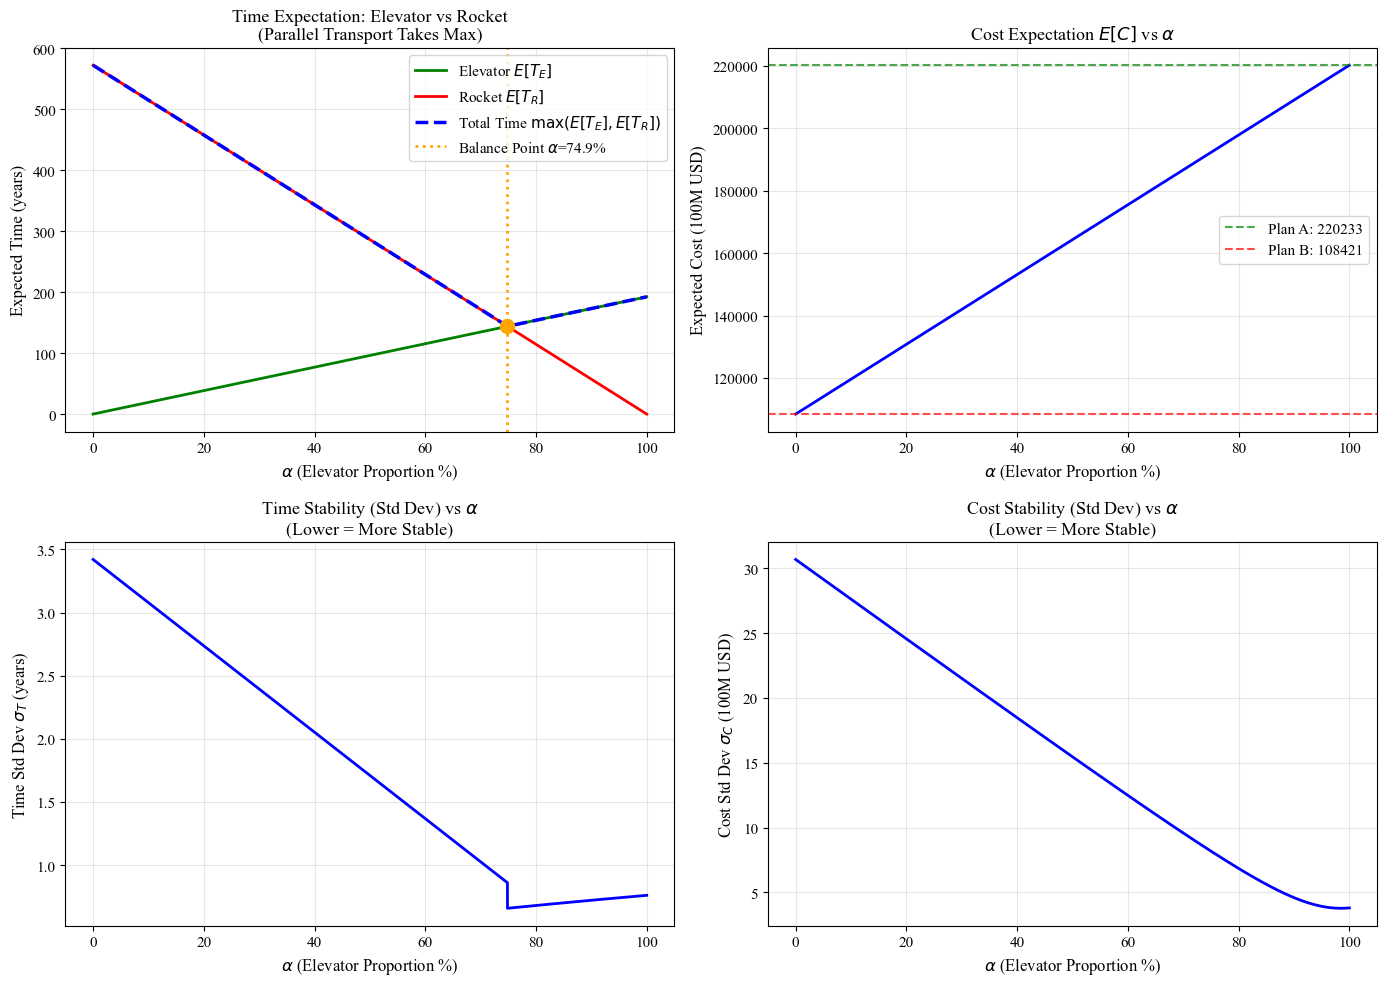

In [21]:
# ==================== Visualization 1: Time Expectation Comparison (Elevator vs Rocket) ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time expectation comparison
ax1 = axes[0, 0]
ax1.plot(alphas * 100, E_T_E_arr, 'g-', linewidth=2, label='Elevator $E[T_E]$')
ax1.plot(alphas * 100, E_T_R_arr, 'r-', linewidth=2, label='Rocket $E[T_R]$')
ax1.plot(alphas * 100, E_T_arr, 'b--', linewidth=2.5, label='Total Time $\\max(E[T_E], E[T_R])$')
# Find crossing point
cross_idx = np.argmin(np.abs(E_T_E_arr - E_T_R_arr))
ax1.axvline(x=alphas[cross_idx]*100, color='orange', linestyle=':', linewidth=2, 
            label=f'Balance Point $\\alpha$={alphas[cross_idx]*100:.1f}%')
ax1.scatter([alphas[cross_idx]*100], [E_T_arr[cross_idx]], color='orange', s=100, zorder=5)
ax1.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax1.set_ylabel('Expected Time (years)', fontsize=12)
ax1.set_title('Time Expectation: Elevator vs Rocket\n(Parallel Transport Takes Max)', fontsize=13)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Cost expectation
ax2 = axes[0, 1]
ax2.plot(alphas * 100, E_C_arr, 'b-', linewidth=2)
ax2.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax2.set_ylabel('Expected Cost (100M USD)', fontsize=12)
ax2.set_title('Cost Expectation $E[C]$ vs $\\alpha$', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=E_C_A, color='g', linestyle='--', alpha=0.7, label=f'Plan A: {E_C_A:.0f}')
ax2.axhline(y=E_C_B, color='r', linestyle='--', alpha=0.7, label=f'Plan B: {E_C_B:.0f}')
ax2.legend()

# Time standard deviation
ax3 = axes[1, 0]
ax3.plot(alphas * 100, Std_T_arr, 'b-', linewidth=2)
ax3.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax3.set_ylabel('Time Std Dev $\\sigma_T$ (years)', fontsize=12)
ax3.set_title('Time Stability (Std Dev) vs $\\alpha$\n(Lower = More Stable)', fontsize=13)
ax3.grid(True, alpha=0.3)

# Cost standard deviation
ax4 = axes[1, 1]
ax4.plot(alphas * 100, Std_C_arr, 'b-', linewidth=2)
ax4.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax4.set_ylabel('Cost Std Dev $\\sigma_C$ (100M USD)', fontsize=12)
ax4.set_title('Cost Stability (Std Dev) vs $\\alpha$\n(Lower = More Stable)', fontsize=13)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/planC_std_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

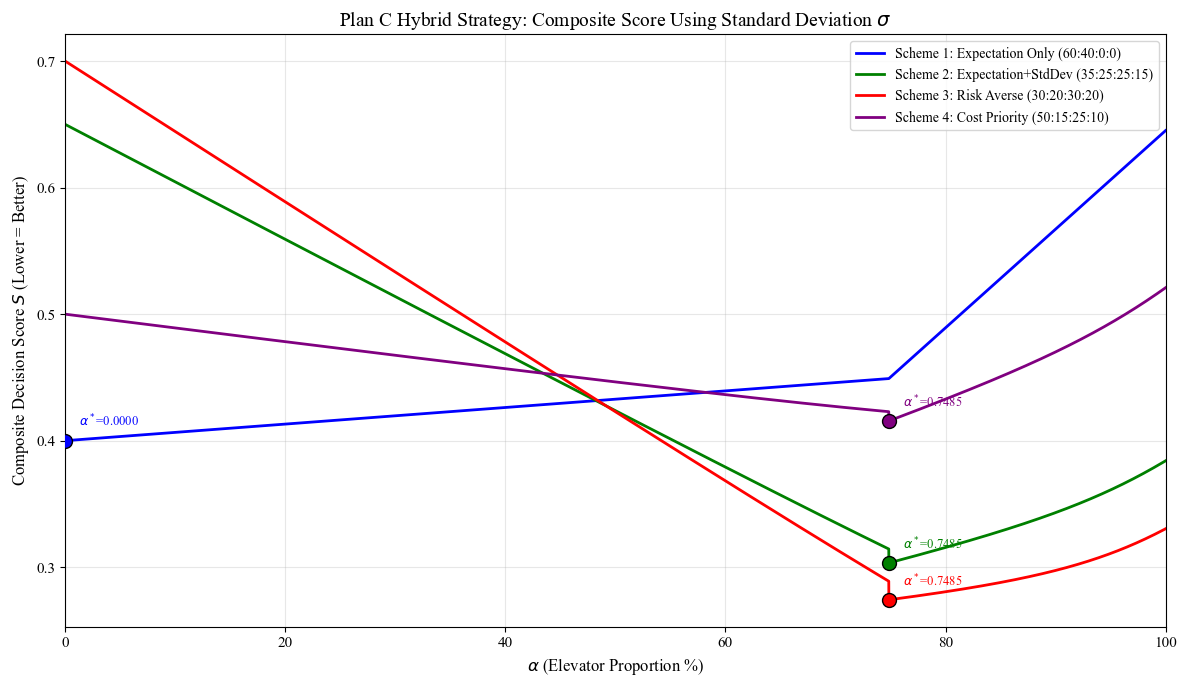

In [22]:
# ==================== Visualization 2: Composite Score Curves (Std Dev Version) ====================
fig, ax = plt.subplots(figsize=(12, 7))

colors = ['blue', 'green', 'red', 'purple']
scheme_labels = {
    '方案1: 仅期望 (60:40:0:0)': 'Scheme 1: Expectation Only (60:40:0:0)',
    '方案2: 期望+标准差 (35:25:25:15)': 'Scheme 2: Expectation+StdDev (35:25:25:15)',
    '方案3: 高风险厌恶 (30:20:30:20)': 'Scheme 3: Risk Averse (30:20:30:20)',
    '方案4: 成本优先 (50:15:25:10)': 'Scheme 4: Cost Priority (50:15:25:10)',
}

for i, (name, (w1, w2, w3, w4)) in enumerate(weight_schemes.items()):
    scores = compute_score_std(w1, w2, w3, w4)
    best_idx = np.argmin(scores)
    label = scheme_labels.get(name, name)
    ax.plot(alphas * 100, scores, '-', color=colors[i], linewidth=2, label=label)
    ax.scatter([alphas[best_idx] * 100], [scores[best_idx]], 
               color=colors[i], s=100, zorder=5, edgecolors='black')
    ax.annotate(f'$\\alpha^*$={alphas[best_idx]:.4f}', 
                (alphas[best_idx] * 100, scores[best_idx]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, color=colors[i])

ax.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax.set_ylabel('Composite Decision Score $S$ (Lower = Better)', fontsize=12)
ax.set_title('Plan C Hybrid Strategy: Composite Score Using Standard Deviation $\\sigma$', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('../results/planC_std_score.png', dpi=300, bbox_inches='tight')
plt.show()

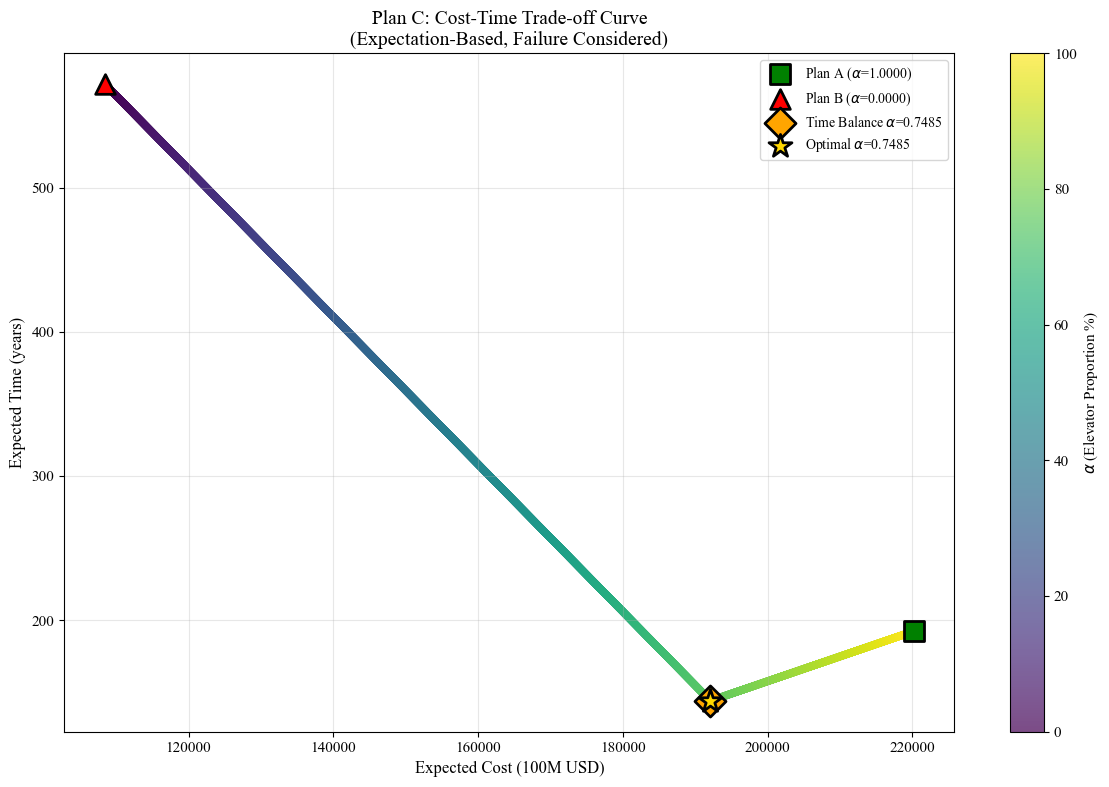

In [23]:
# ==================== Visualization 3: Pareto Frontier ====================
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(E_C_arr, E_T_arr, c=alphas*100, cmap='viridis', s=20, alpha=0.7)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('$\\alpha$ (Elevator Proportion %)', fontsize=11)

# Mark key points
ax.scatter([E_C_A], [E_T_A], color='green', s=200, marker='s', 
           edgecolors='black', linewidths=2, label='Plan A ($\\alpha$=1.0000)', zorder=10)
ax.scatter([E_C_B], [E_T_B], color='red', s=200, marker='^', 
           edgecolors='black', linewidths=2, label='Plan B ($\\alpha$=0.0000)', zorder=10)

# Mark balance point
ax.scatter([E_C_arr[cross_idx]], [E_T_arr[cross_idx]], color='orange', s=250, marker='D',
           edgecolors='black', linewidths=2, label=f'Time Balance $\\alpha$={alphas[cross_idx]:.4f}', zorder=10)

# Mark optimal point
best_alpha = optimal_results['方案2: 期望+标准差 (35:25:25:15)']['alpha']
best_idx = int(best_alpha * 10000)
ax.scatter([E_C_arr[best_idx]], [E_T_arr[best_idx]], color='gold', s=300, marker='*',
           edgecolors='black', linewidths=2, label=f'Optimal $\\alpha$={best_alpha:.4f}', zorder=10)

ax.set_xlabel('Expected Cost (100M USD)', fontsize=12)
ax.set_ylabel('Expected Time (years)', fontsize=12)
ax.set_title('Plan C: Cost-Time Trade-off Curve\n(Expectation-Based, Failure Considered)', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/planC_std_pareto.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# ==================== 对比: CV vs 标准差 ====================
print("=" * 70)
print("CV vs 标准差 对比分析")
print("=" * 70)

# 计算CV
CV_T_arr = Std_T_arr / E_T_arr
CV_C_arr = Std_C_arr / E_C_arr

print(f"\n【时间稳定性】")
print(f"  标准差 σ_T 范围: {Std_T_arr.min():.4f} ~ {Std_T_arr.max():.4f} 年")
print(f"  标准差差异: {Std_T_arr.max() - Std_T_arr.min():.4f} 年")
print(f"  CV_T 范围: {CV_T_arr.min():.6f} ~ {CV_T_arr.max():.6f}")
print(f"  CV差异: {CV_T_arr.max() - CV_T_arr.min():.6f}")

print(f"\n【成本稳定性】")
print(f"  标准差 σ_C 范围: {Std_C_arr.min():.4f} ~ {Std_C_arr.max():.4f} 亿USD")
print(f"  标准差差异: {Std_C_arr.max() - Std_C_arr.min():.4f} 亿USD")
print(f"  CV_C 范围: {CV_C_arr.min():.6f} ~ {CV_C_arr.max():.6f}")
print(f"  CV差异: {CV_C_arr.max() - CV_C_arr.min():.6f}")

print(f"\n【结论】")
print(f"  CV的变化范围非常小 (时间CV差异仅{(CV_T_arr.max() - CV_T_arr.min())*100:.4f}%)")
print(f"  使用标准差可以更好地区分不同α下的稳定性差异")

CV vs 标准差 对比分析

【时间稳定性】
  标准差 σ_T 范围: 0.6581 ~ 3.4208 年
  标准差差异: 2.7627 年
  CV_T 范围: 0.003956 ~ 0.005980
  CV差异: 0.002024

【成本稳定性】
  标准差 σ_C 范围: 3.7743 ~ 30.6892 亿USD
  标准差差异: 26.9150 亿USD
  CV_C 范围: 0.000017 ~ 0.000283
  CV差异: 0.000266

【结论】
  CV的变化范围非常小 (时间CV差异仅0.2024%)
  使用标准差可以更好地区分不同α下的稳定性差异


In [25]:
# ==================== 最终结论 ====================
print("=" * 70)
print("Plan C 混合方案优化 - 最终结论 (标准差版)")
print("=" * 70)

rec = optimal_results['方案2: 期望+标准差 (35:25:25:15)']
alpha_opt = rec['alpha']

print(f"""
【推荐最优解】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
最优 α* = {alpha_opt:.4f}

资源分配:
  • 太空电梯运输: {alpha_opt * M / 10**6:.2f} 万吨 ({alpha_opt*100:.2f}%)
  • 火箭运输: {(1-alpha_opt) * M / 10**6:.2f} 万吨 ({(1-alpha_opt)*100:.2f}%)

预期结果 (基于期望，考虑故障):
  • 总时间: {rec['E_T']:.2f} 年 (σ={rec['Std_T']:.4f}年)
  • 总成本: {rec['E_C']:.2f} 亿USD (σ={rec['Std_C']:.4f}亿USD)

对比纯方案:
  Plan A (纯电梯): {E_T_A:.2f}年, {E_C_A:.2f}亿USD
  Plan B (纯火箭): {E_T_B:.2f}年, {E_C_B:.2f}亿USD
  Plan C (混合):   {rec['E_T']:.2f}年, {rec['E_C']:.2f}亿USD ✓

时间平衡点: α = {alphas[cross_idx]:.4f}
  (此时电梯和火箭运输时间相等)

【决策函数公式】(使用标准差)
S(α) = 0.35·Ẽ_C + 0.25·Ẽ_T + 0.25·σ̃_C + 0.15·σ̃_T

其中:
  - Ẽ_C, Ẽ_T: 归一化后的成本和时间期望
  - σ̃_C, σ̃_T: 归一化后的成本和时间标准差
  - 稳定性总权重: 40%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print("图像已保存到 results/ 目录:")
print("  1. planC_std_metrics.png - 期望和标准差随α变化")
print("  2. planC_std_score.png - 综合得分曲线")
print("  3. planC_std_pareto.png - Pareto前沿")

Plan C 混合方案优化 - 最终结论 (标准差版)

【推荐最优解】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
最优 α* = 0.7485

资源分配:
  • 太空电梯运输: 74.85 万吨 (74.85%)
  • 火箭运输: 25.15 万吨 (25.15%)

预期结果 (基于期望，考虑故障):
  • 总时间: 143.92 年 (σ=0.6581年)
  • 总成本: 192112.23 亿USD (σ=8.2266亿USD)

对比纯方案:
  Plan A (纯电梯): 192.27年, 220232.92亿USD
  Plan B (纯火箭): 572.08年, 108421.05亿USD
  Plan C (混合):   143.92年, 192112.23亿USD ✓

时间平衡点: α = 0.7485
  (此时电梯和火箭运输时间相等)

【决策函数公式】(使用标准差)
S(α) = 0.35·Ẽ_C + 0.25·Ẽ_T + 0.25·σ̃_C + 0.15·σ̃_T

其中:
  - Ẽ_C, Ẽ_T: 归一化后的成本和时间期望
  - σ̃_C, σ̃_T: 归一化后的成本和时间标准差
  - 稳定性总权重: 40%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

图像已保存到 results/ 目录:
  1. planC_std_metrics.png - 期望和标准差随α变化
  2. planC_std_score.png - 综合得分曲线
  3. planC_std_pareto.png - Pareto前沿
